In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import random
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add,Layer, Lambda
from tensorflow.keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add,Layer, Lambda
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import subprocess
import os
from sklearn.utils import column_or_1d
from sklearn.utils.multiclass import type_of_target
import gc
import torch
from numba import cuda 
from sklearn.utils import column_or_1d
from sklearn.utils.multiclass import type_of_target
import seaborn as sns
from sklearn.metrics import f1_score
import pickle
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_score, recall_score, f1_score
import importlib
from matplotlib.pyplot import figure
from scipy import stats
from scipy.signal import find_peaks
import seaborn as sns
from matplotlib.patches import Patch

/opt/scp/.dev/tf/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data Prep

Run ComPPlete to study homodimers and heterodimers within 170 GPCR proteins. But, this code can be modified to run for any pair of proteins.

In [2]:
GPCR_data = pd.read_csv('GPCRs_seq.csv', index_col=0)
GPCR_data

,symbol,prot_seq
0,AGTR1,MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGN...
1,AGTR2,MKGNSTLATTSKNITSGLHFGLVNISGNNESTLNCSQKPSDKHLDA...
2,APJ,MEEGGDFDNYYGADNQSECEYTDWKSSGALIPAIYMLVFLLGTTGN...
3,NMBR,MPSKSLSNLSVTTGANESGSVPEGWERDFLPASDGTTTELVIRCVI...
4,GRPR,MALNDCFLLNLEVDHFMHCNISSHSADLPVNDDWSHPGILYVIPAV...
...,...,...
165,OPN4,MNPPSGPRVPPSPTQEPSCMATPAPPSWWDSSQSSISSLGRLPSIS...
166,OPN5,MALNHTALPQDERLPHYLRDGDPFASKLSWEADLVAGFYLTIIGIL...
167,OPSB,MSEEEFYLFKNISSVGPWDGPQYHIAPVWAFYLQAAFMGTVFLIGF...
168,OPSG,MAQQWSLQRLAGRHPQDSYEDSTQSSIFTYTNSNSTRGPFEGPNYH...


In [3]:
protvec_model = pd.read_csv('protVec_100d_3grams.csv', delimiter = '\t')

protvec_trigram_dict = {}

for idx, row in protvec_model.iterrows():
    protvec_trigram_dict[row['words']] = protvec_model.iloc[idx, 1:].values.astype(np.float64)
    
trigram_list = set(protvec_trigram_dict.keys())

def get_protvec(prot_seq):
    n = 3
    split_by_three = [prot_seq[i : i + n] for i in range(0, len(prot_seq), n)]

    split_by_three

    num_trigrams = len(split_by_three)

    num_trigrams

    target_embeddings = np.zeros(100) # 100 is protvec number of dimentions

    for trigram in split_by_three: 

        if len(trigram) == 2: 
            trigram = "X" + trigram

        elif len(trigram) == 1:
            trigram = "XX" + trigram

        if trigram in trigram_list:
            target_embeddings = target_embeddings + protvec_trigram_dict[trigram]

    return target_embeddings

In [4]:
GPCR_dict = dict()
for index, row in tqdm(GPCR_data.iterrows()):
    GPCR_dict[row['symbol']] = dict()
    GPCR_dict[row['symbol']]['aaseq'] = row['prot_seq']
    GPCR_dict[row['symbol']]['protvec'] = get_protvec(row['prot_seq'])

170it [00:00, 4782.85it/s]


In [5]:
GPCR_all = pd.DataFrame()
GPCR_symbols = list(GPCR_dict.keys())
SymbolA = []
SymbolB = []

for k1 in tqdm(GPCR_symbols):
    for k2 in GPCR_symbols:
        SymbolA.append(k1)
        SymbolB.append(k2)
        
GPCR_all['SymbolA'] = SymbolA
GPCR_all['SymbolB'] = SymbolB

GPCR_all

100%|██████████| 170/170 [00:00<00:00, 63033.21it/s]


,SymbolA,SymbolB
0,AGTR1,AGTR1
1,AGTR1,AGTR2
2,AGTR1,APJ
3,AGTR1,NMBR
4,AGTR1,GRPR
...,...,...
28895,OPSR,OPN4
28896,OPSR,OPN5
28897,OPSR,OPSB
28898,OPSR,OPSG


In [6]:
# GPCR_symbols

# ComPPlete

In [7]:
X = []

    
for index, row in tqdm(GPCR_all.iterrows()):
    prot1 = GPCR_dict[row['SymbolA']]['protvec']
    prot2 = GPCR_dict[row['SymbolB']]['protvec']
    X.append(list(prot1) + list(prot2))

28900it [00:01, 19637.80it/s]


In [8]:
f = 5
prediction_folds = []

for j in range(f):

    model = load_model('../models/compplete_02_12_2024_fold' + str(j) + '.h5')

    X = np.array(X)  
    pred = model.predict([X[:,:100],X[:,100:]])
    prediction_folds.append([x[0] for x in pred])

904/904 [==============================] - 1s 1ms/step


In [9]:
GPCR_all = pd.DataFrame()

GPCR_all['SymbolA'] = SymbolA
GPCR_all['SymbolB'] = SymbolB

GPCR_all['pred_fold0'] = prediction_folds[0]
GPCR_all['pred_fold1'] = prediction_folds[1]
GPCR_all['pred_fold2'] = prediction_folds[2]
GPCR_all['pred_fold3'] = prediction_folds[3]
GPCR_all['pred_fold4'] = prediction_folds[4]

GPCR_all['average'] = GPCR_all[['pred_fold0', 'pred_fold1', 'pred_fold2', 'pred_fold3', 'pred_fold4']].mean(axis=1)

GPCR_all['std'] = GPCR_all[['pred_fold0', 'pred_fold1', 'pred_fold2', 'pred_fold3', 'pred_fold4']].std(axis=1)

In [10]:
GPCR_all.to_csv('output/GPCRS_all_preds.csv')

In [11]:
GPCR_symbols_df = pd.DataFrame()
GPCR_symbols_df['Symbols'] = GPCR_symbols
# GPCR_symbols_df.to_csv('GPCR_list.csv')

In [12]:
GPCR_all = GPCR_all.sort_values('average', ascending=False)

In [13]:
GPCR_all['pair'] = GPCR_all[['SymbolA', 'SymbolB']].apply(lambda r: '__'.join(sorted(r)), axis=1)
 
GPCR_all = GPCR_all.drop_duplicates('pair').reset_index(drop=True)

In [14]:
GPCR_all_pos = GPCR_all.head(100) #GPCR_all[GPCR_all['average']>0.95]

In [15]:
GPCR_all.head(100)

,SymbolA,SymbolB,pred_fold0,pred_fold1,pred_fold2,pred_fold3,pred_fold4,average,std,pair
0,FFAR4,FFAR4,0.960627,0.966220,0.995191,0.987825,0.948460,0.971665,0.019394,FFAR4__FFAR4
1,OXYR,FFAR4,0.942801,0.962630,0.997534,0.984516,0.954134,0.968323,0.022364,FFAR4__OXYR
2,SSR2,FFAR4,0.960139,0.947267,0.982506,0.986459,0.961459,0.967566,0.016467,FFAR4__SSR2
3,C5AR1,FFAR4,0.951849,0.944860,0.990200,0.977768,0.960230,0.964981,0.018704,C5AR1__FFAR4
4,OPN3,FFAR4,0.939233,0.952138,0.976109,0.985542,0.967591,0.964122,0.018558,FFAR4__OPN3
...,...,...,...,...,...,...,...,...,...,...
95,ACKR4,AGTR2,0.935349,0.902637,0.956175,0.953517,0.929608,0.935457,0.021603,ACKR4__AGTR2
96,PE2R3,LPAR4,0.906537,0.947831,0.978812,0.949676,0.894095,0.935390,0.034576,LPAR4__PE2R3
97,BKRB1,AGTR2,0.947135,0.857689,0.975035,0.964008,0.932846,0.935343,0.046294,AGTR2__BKRB1
98,C5AR1,CLTR2,0.919634,0.887359,0.989572,0.951468,0.928123,0.935231,0.038086,C5AR1__CLTR2


In [16]:
GPCR_all_pos[GPCR_all_pos['SymbolA']==GPCR_all_pos['SymbolB']]

,SymbolA,SymbolB,pred_fold0,pred_fold1,pred_fold2,pred_fold3,pred_fold4,average,std,pair
0,FFAR4,FFAR4,0.960627,0.966220,0.995191,0.987825,0.948460,0.971665,0.019394,FFAR4__FFAR4
5,OXYR,OXYR,0.945144,0.935741,0.997672,0.979071,0.959727,0.963471,0.025159,OXYR__OXYR
6,SSR2,SSR2,0.949583,0.939674,0.983410,0.980529,0.959975,0.962634,0.019082,SSR2__SSR2
37,MTR1A,MTR1A,0.920105,0.899957,0.993760,0.979639,0.955572,0.949807,0.039441,MTR1A__MTR1A
45,C5AR1,C5AR1,0.941623,0.891765,0.982051,0.954168,0.965280,0.946977,0.034256,C5AR1__C5AR1
52,MTLR,MTLR,0.947540,0.968074,0.989940,0.978055,0.841085,0.944939,0.060103,MTLR__MTLR
78,BKRB1,BKRB1,0.944529,0.870761,0.994476,0.947441,0.949820,0.941405,0.044509,BKRB1__BKRB1
87,P2RY1,P2RY1,0.933399,0.899184,0.996594,0.957674,0.903158,0.938002,0.040504,P2RY1__P2RY1


In [17]:
G = nx.Graph()

In [18]:
G.add_edges_from(zip(GPCR_all_pos['SymbolA'],GPCR_all_pos['SymbolB']))

In [19]:
G.number_of_nodes()

28

In [20]:
G.number_of_edges()

100

Text(0, 0.5, 'Number of Interactions')

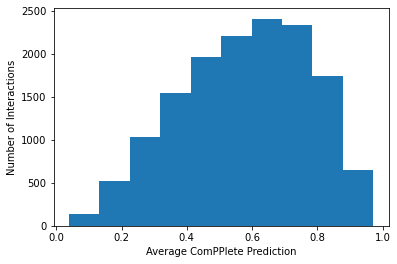

In [21]:
plt.hist(GPCR_all['average'])
plt.xlabel('Average ComPPlete Prediction')
plt.ylabel('Number of Interactions')

Text(0, 0.5, 'Number of Interactions')

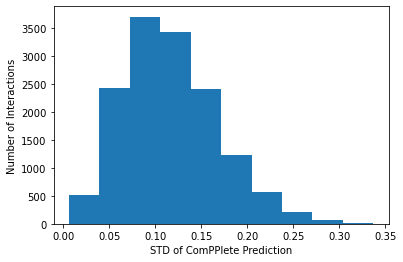

In [22]:
plt.hist(GPCR_all['std'])
plt.xlabel('STD of ComPPlete Prediction')
plt.ylabel('Number of Interactions')

In [23]:
len(GPCR_all)

14535

In [24]:
len(GPCR_all[GPCR_all['average']>0.5])

9449

In [25]:
len(GPCR_all[GPCR_all['average']>0.9])

392

In [26]:
len(GPCR_all[GPCR_all['average']>0.95])

37

In [27]:
# GPCR_all_pos.to_csv('GPCR_Network_ComPPlete_02_26_2024.csv')

Text(0, 0.5, 'STD of ComPPlete Prediction')

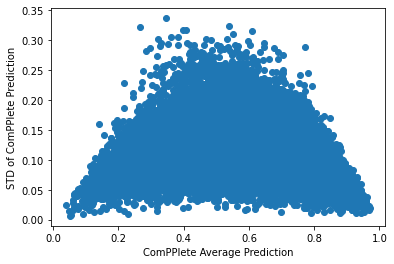

In [28]:
plt.scatter(GPCR_all['average'],GPCR_all['std'])
plt.xlabel('ComPPlete Average Prediction')
plt.ylabel('STD of ComPPlete Prediction')